In [0]:
import numpy as np
import torch
import torchvision
import pickle


import matplotlib.pyplot  as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('drive/My Drive/Colab Notebooks/colored-mnist.pkl', 'rb') as f:
    data = pickle.load(f)

In [0]:
train = data['train']
test = data['test']

In [0]:
print("Count train samples: ", train.shape[0])
print("Count test samples: ", test.shape[0])
print("Shape of image (H, W, C): ", train[0].shape)

Count train samples:  60000
Count test samples:  10000
Shape of image (H, W, C):  (28, 28, 3)


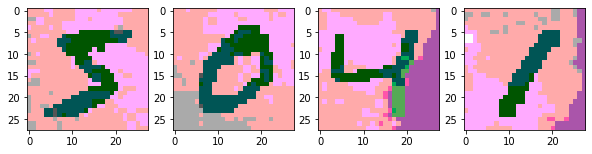

In [0]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  print_image =  image * (255 / 3)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(print_image.astype(int))
  

for i in range(0, 4):
  show_image(i, train[i])
plt.show()

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, target, transform=None):
      self.target = torch.from_numpy(target).permute(0, 3, 1, 2)
      self.transform = transform
      
  def __getitem__(self, index):
      y = self.target[index]
      
      if self.transform:
          y = self.transform(y)
          
      return y
  
  def __len__(self):
      return len(self.target)

In [0]:
BATCHSIZE = 100

In [0]:
train_ds = MyDataset(train)
test_ds = MyDataset(test)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSIZE)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSIZE)

In [0]:
dataiter = iter(trainloader)
labels = dataiter.next()
print("Tensor shape: ", labels.shape)

Tensor shape:  torch.Size([100, 3, 28, 28])


## Masking

- ConvLayer 7x7 needs Mask A

- The Convlayers in the residual Blocks need the Mask B 


### Example for 3x3 Filter
- Mask A:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

- Mask B:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

In [0]:
class ResBlock(torch.nn.Module):

  def __init__(self, channels=64):
    super(ResBlock, self).__init__()
    self.channels=channels

    self.network = torch.nn.Sequential(
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0), 
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        MaskedConv2d('B',self.channels, self.channels, 3, stride=1, padding=1),
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0),
        torch.nn.BatchNorm2d(2*self.channels)
      )
    
  def forward(self, x):
    out= self.network(x)
    return x + out


In [0]:
# Quelle: https://www.codeproject.com/Articles/5061271/PixelCNN-in-Autoregressive-Models
class MaskedConv2d(torch.nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)
    assert mask_type in ('A', 'B')
    self.register_buffer('mask', self.weight.data.clone())
    _, _, fH, fW = self.weight.size()
    
    self.mask.fill_(1)
    if (mask_type == 'B'): 
      self.mask[:, :, fH // 2, fW // 2 + 1:] = 0
    else:
      self.mask[:, :, fH // 2, fW // 2:] = 0
    
    self.mask[:, :, fH // 2 + 1:] = 0

  def forward(self, x):
    self.weight.data *= self.mask
    return super(MaskedConv2d, self).forward(x)

In [0]:
class PixelCNN(torch.nn.Module):
    
  def __init__(self, channels=16, res_blocks=12): 
    super(PixelCNN,self).__init__()
    layers = []
    layers.append(MaskedConv2d("A", 3, channels*2, 7, padding=3))

    for i in range(res_blocks):
      layers.append(ResBlock(channels))

    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(channels*2, 1024, 1, 1, 0))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(1024, 3*4, 1, 1, 0))

    self.network = torch.nn.Sequential(*layers)
   
  def forward(self, x):
    batch_size = x.shape[0]
    pixel_cnn = self.network(x).view(batch_size, 4, 3, 28, 28)
    return pixel_cnn

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
pixelCNN = PixelCNN(128).to(device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  pixelCNN = torch.nn.DataParallel(pixelCNN)

In [0]:
device

device(type='cuda', index=0)

In [0]:
torch.cuda.device_count()

1

In [0]:
optimizer = torch.optim.Adam(pixelCNN.parameters(),lr=3e-4, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
def sample_image(batch_size=4):
  image = torch.Tensor(np.random.choice(4, size=(batch_size, 3, 28, 28))).type(torch.FloatTensor).cuda()
  
   
  for i in range(28):
    for j in range(28):
      for k in range(3):
        with torch.no_grad():
          out = pixelCNN(image).permute(0, 2, 3, 4, 1)

        p = torch.nn.functional.softmax(out[:, k, i, j], dim=1).data
        pixel = torch.multinomial(p, 1)
        image[:, k, i, j] = pixel.view(-1)
  

  image = image.permute(0,2,3,1).cpu().detach().numpy().astype(int)  
  image = image * (255 / 3)

  if batch_size==4:
    fig = plt.figure(figsize=(10, 10))
    image = image.reshape(4, 28, 28, 3)
    for i in range(0, 4):
      fig.add_subplot(1, 4, i+1)
      print_image = image[i,:,:,:]
      plt.imshow(print_image.astype(int))
    plt.show()
  else:
    fig, axs = plt.subplots(20, 5, figsize=(20, 50))
    count = 0

    for i in range(20):
      for j in range(5):
        temp_image = image[count,:,:,:].astype(int)
        count += 1
        axs[i][j].imshow(temp_image.reshape(28,28,3))

    plt.show()
  return image

epoch: 0 i: 99 loss: 0.24267765879631042 val loss: 0.2346222847700119
epoch: 0 i: 199 loss: 0.19591592252254486 val loss: 0.19522006809711456
epoch: 0 i: 299 loss: 0.16550549864768982 val loss: 0.16928012669086456
epoch: 0 i: 399 loss: 0.15776021778583527 val loss: 0.15575429797172546
epoch: 0 i: 499 loss: 0.14386148750782013 val loss: 0.1411277800798416
epoch: 0 i: 599 loss: 0.15001541376113892 val loss: 0.13983064889907837


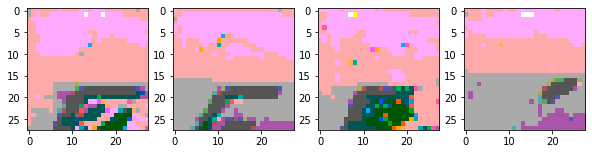

epoch: 1 i: 99 loss: 0.12917791306972504 val loss: 0.12301424145698547
epoch: 1 i: 199 loss: 0.12255550920963287 val loss: 0.11543870717287064
epoch: 1 i: 299 loss: 0.11297070235013962 val loss: 0.1102856695652008
epoch: 1 i: 399 loss: 0.10981602221727371 val loss: 0.10555318742990494
epoch: 1 i: 499 loss: 0.10457952320575714 val loss: 0.10238835960626602
epoch: 1 i: 599 loss: 0.11204355955123901 val loss: 0.1061069518327713


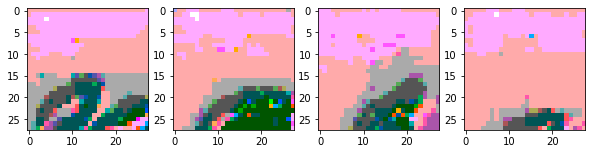

epoch: 2 i: 99 loss: 0.10254758596420288 val loss: 0.09896264225244522
epoch: 2 i: 199 loss: 0.10526634007692337 val loss: 0.09949971735477448
epoch: 2 i: 299 loss: 0.10060472041368484 val loss: 0.09881511330604553
epoch: 2 i: 399 loss: 0.10106615722179413 val loss: 0.09770273417234421
epoch: 2 i: 499 loss: 0.09796357154846191 val loss: 0.09569716453552246
epoch: 2 i: 599 loss: 0.10603021830320358 val loss: 0.09952564537525177


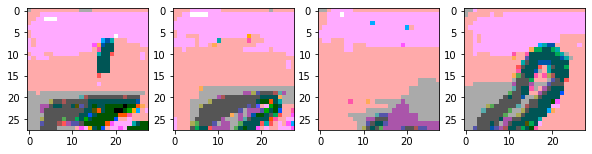

epoch: 3 i: 99 loss: 0.09783052653074265 val loss: 0.09431217610836029
epoch: 3 i: 199 loss: 0.10113765299320221 val loss: 0.09528496861457825
epoch: 3 i: 299 loss: 0.09663023799657822 val loss: 0.09479230642318726
epoch: 3 i: 399 loss: 0.09805119782686234 val loss: 0.09471121430397034
epoch: 3 i: 499 loss: 0.09474559873342514 val loss: 0.09326019883155823
epoch: 3 i: 599 loss: 0.10312681645154953 val loss: 0.09725514054298401


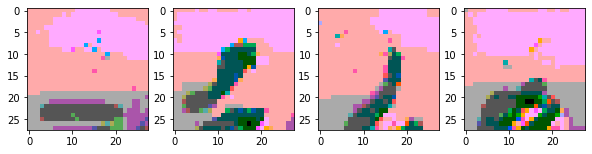

epoch: 4 i: 99 loss: 0.09513715654611588 val loss: 0.09210763871669769
epoch: 4 i: 199 loss: 0.09791403263807297 val loss: 0.09252927452325821
epoch: 4 i: 299 loss: 0.094388447701931 val loss: 0.0932147428393364
epoch: 4 i: 399 loss: 0.09501469135284424 val loss: 0.09281481057405472
epoch: 4 i: 499 loss: 0.09247803688049316 val loss: 0.0911751240491867
epoch: 4 i: 599 loss: 0.1003757044672966 val loss: 0.0949014201760292


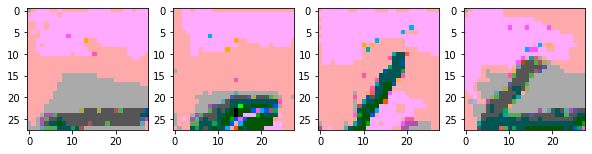

epoch: 5 i: 99 loss: 0.09301867336034775 val loss: 0.09032885730266571
epoch: 5 i: 199 loss: 0.09544474631547928 val loss: 0.0909307524561882
epoch: 5 i: 299 loss: 0.09267649054527283 val loss: 0.0912461131811142
epoch: 5 i: 399 loss: 0.0933661237359047 val loss: 0.09047861397266388
epoch: 5 i: 499 loss: 0.09090306609869003 val loss: 0.08946813642978668
epoch: 5 i: 599 loss: 0.099854476749897 val loss: 0.0947059765458107


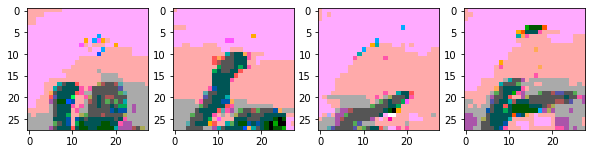

epoch: 6 i: 99 loss: 0.09169598668813705 val loss: 0.08868760615587234
epoch: 6 i: 199 loss: 0.09349240362644196 val loss: 0.08918184041976929
epoch: 6 i: 299 loss: 0.09092151373624802 val loss: 0.08910415321588516
epoch: 6 i: 399 loss: 0.09211172163486481 val loss: 0.0888947919011116
epoch: 6 i: 499 loss: 0.08964817225933075 val loss: 0.08869513124227524
epoch: 6 i: 599 loss: 0.09712453186511993 val loss: 0.0915083959698677


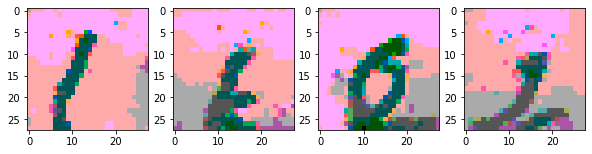

epoch: 7 i: 99 loss: 0.08933939784765244 val loss: 0.08707073330879211
epoch: 7 i: 199 loss: 0.0928066298365593 val loss: 0.0881725624203682
epoch: 7 i: 299 loss: 0.08981386572122574 val loss: 0.087533138692379
epoch: 7 i: 399 loss: 0.0908457562327385 val loss: 0.08811833709478378
epoch: 7 i: 499 loss: 0.08825615793466568 val loss: 0.08674823492765427
epoch: 7 i: 599 loss: 0.09496375173330307 val loss: 0.09068594872951508


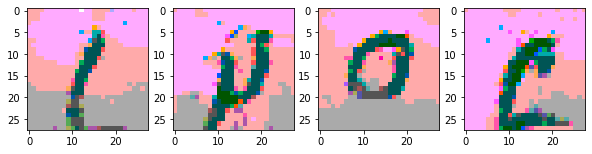

epoch: 8 i: 99 loss: 0.08793586492538452 val loss: 0.08580945432186127
epoch: 8 i: 199 loss: 0.09212686866521835 val loss: 0.08673866093158722
epoch: 8 i: 299 loss: 0.08860383182764053 val loss: 0.08686250448226929
epoch: 8 i: 399 loss: 0.09014920890331268 val loss: 0.08687964081764221
epoch: 8 i: 499 loss: 0.08748603612184525 val loss: 0.0857553780078888
epoch: 8 i: 599 loss: 0.09516533464193344 val loss: 0.09083940833806992


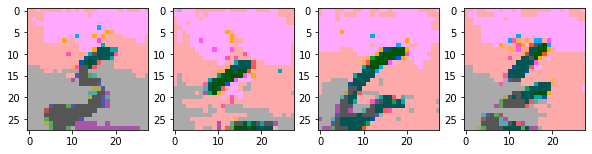

epoch: 9 i: 99 loss: 0.08717914670705795 val loss: 0.08530542999505997
epoch: 9 i: 199 loss: 0.09027819335460663 val loss: 0.08605172485113144
epoch: 9 i: 299 loss: 0.0880444347858429 val loss: 0.08601296693086624
epoch: 9 i: 399 loss: 0.08941421657800674 val loss: 0.08595847338438034
epoch: 9 i: 499 loss: 0.08649558573961258 val loss: 0.08491596579551697
epoch: 9 i: 599 loss: 0.094809390604496 val loss: 0.09057193994522095


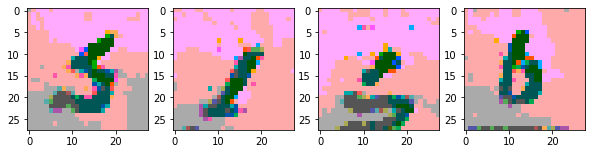

epoch: 10 i: 99 loss: 0.08634041994810104 val loss: 0.08443523943424225
epoch: 10 i: 199 loss: 0.13943909108638763 val loss: 0.1393508017063141
epoch: 10 i: 299 loss: 0.11045177280902863 val loss: 0.10683190077543259
epoch: 10 i: 399 loss: 0.10515544563531876 val loss: 0.10027853399515152
epoch: 10 i: 499 loss: 0.09966272115707397 val loss: 0.09741456061601639
epoch: 10 i: 599 loss: 0.10534622520208359 val loss: 0.0987442210316658


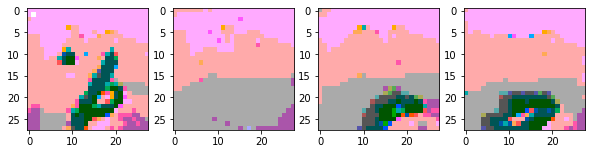

epoch: 11 i: 99 loss: 0.09746857732534409 val loss: 0.09341486543416977
epoch: 11 i: 199 loss: 0.0978081226348877 val loss: 0.09313233941793442
epoch: 11 i: 299 loss: 0.09525597095489502 val loss: 0.09170009195804596
epoch: 11 i: 399 loss: 0.09577896445989609 val loss: 0.09075896441936493
epoch: 11 i: 499 loss: 0.092423215508461 val loss: 0.09007681161165237
epoch: 11 i: 599 loss: 0.09875298291444778 val loss: 0.09262736886739731


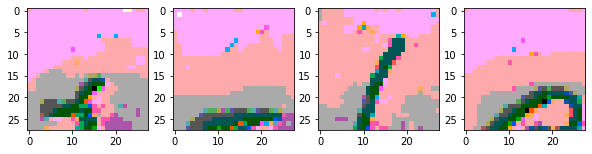

epoch: 12 i: 99 loss: 0.09167557954788208 val loss: 0.08838360011577606
epoch: 12 i: 199 loss: 0.09374000132083893 val loss: 0.08873024582862854
epoch: 12 i: 299 loss: 0.09123297780752182 val loss: 0.08814896643161774
epoch: 12 i: 399 loss: 0.09155642241239548 val loss: 0.08712241798639297
epoch: 12 i: 499 loss: 0.08934062719345093 val loss: 0.08696896582841873
epoch: 12 i: 599 loss: 0.09576618671417236 val loss: 0.08918069303035736


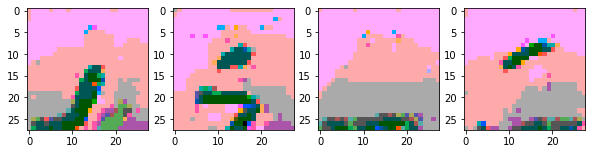

epoch: 13 i: 99 loss: 0.08846376091241837 val loss: 0.08533785492181778
epoch: 13 i: 199 loss: 0.09061124175786972 val loss: 0.08603418618440628
epoch: 13 i: 299 loss: 0.08918498456478119 val loss: 0.08630821853876114
epoch: 13 i: 399 loss: 0.08988020569086075 val loss: 0.08566571027040482
epoch: 13 i: 499 loss: 0.08782146871089935 val loss: 0.08550228178501129
epoch: 13 i: 599 loss: 0.09359140694141388 val loss: 0.087611623108387


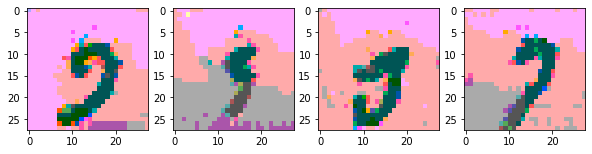

epoch: 14 i: 99 loss: 0.08704110234975815 val loss: 0.08410719037055969
epoch: 14 i: 199 loss: 0.08955512940883636 val loss: 0.08515357971191406
epoch: 14 i: 299 loss: 0.08815009146928787 val loss: 0.08535565435886383
epoch: 14 i: 399 loss: 0.08904817700386047 val loss: 0.084691122174263
epoch: 14 i: 499 loss: 0.08654259145259857 val loss: 0.08430716395378113
epoch: 14 i: 599 loss: 0.09265806525945663 val loss: 0.08696957677602768


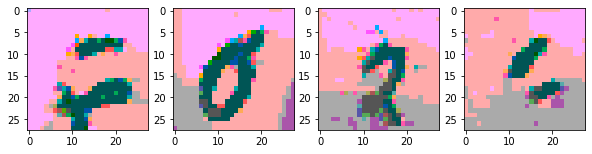

epoch: 15 i: 99 loss: 0.08606715500354767 val loss: 0.08348660916090012
epoch: 15 i: 199 loss: 0.08846314251422882 val loss: 0.08467019349336624
epoch: 15 i: 299 loss: 0.08758844435214996 val loss: 0.08468722552061081
epoch: 15 i: 399 loss: 0.08828914910554886 val loss: 0.08424010872840881
epoch: 15 i: 499 loss: 0.08611325919628143 val loss: 0.08380433171987534
epoch: 15 i: 599 loss: 0.09191972017288208 val loss: 0.08625763654708862


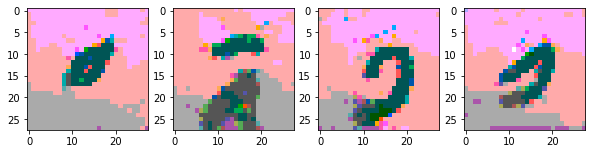

epoch: 16 i: 99 loss: 0.08536823093891144 val loss: 0.08299899101257324
epoch: 16 i: 199 loss: 0.08773145824670792 val loss: 0.08432504534721375
epoch: 16 i: 299 loss: 0.08727649599313736 val loss: 0.08445534855127335
epoch: 16 i: 399 loss: 0.08810876309871674 val loss: 0.08387967199087143
epoch: 16 i: 499 loss: 0.08596726506948471 val loss: 0.08302097767591476
epoch: 16 i: 599 loss: 0.09138491749763489 val loss: 0.08733435720205307


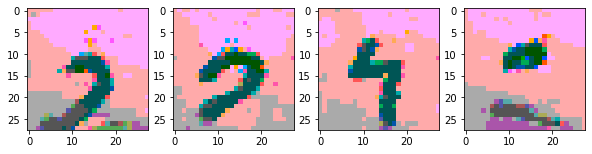

epoch: 17 i: 99 loss: 0.08477987349033356 val loss: 0.0826818123459816
epoch: 17 i: 199 loss: 0.0871477797627449 val loss: 0.08382346481084824
epoch: 17 i: 299 loss: 0.08632691204547882 val loss: 0.08409932255744934
epoch: 17 i: 399 loss: 0.08733382821083069 val loss: 0.083399698138237
epoch: 17 i: 499 loss: 0.08529679477214813 val loss: 0.08285979926586151
epoch: 17 i: 599 loss: 0.09049628674983978 val loss: 0.0860019326210022


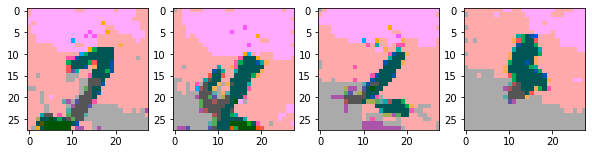

epoch: 18 i: 99 loss: 0.08425485342741013 val loss: 0.08246830850839615
epoch: 18 i: 199 loss: 0.08683212101459503 val loss: 0.0830540880560875
epoch: 18 i: 299 loss: 0.0861559808254242 val loss: 0.08342505991458893
epoch: 18 i: 399 loss: 0.08726333826780319 val loss: 0.08322586119174957
epoch: 18 i: 499 loss: 0.08468394726514816 val loss: 0.08261088281869888
epoch: 18 i: 599 loss: 0.0901433452963829 val loss: 0.08562636375427246


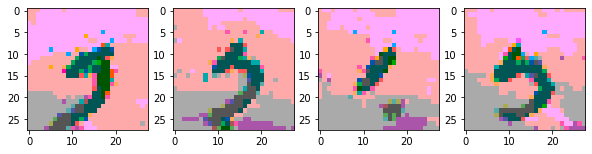

epoch: 19 i: 99 loss: 0.08415599912405014 val loss: 0.08208052814006805
epoch: 19 i: 199 loss: 0.08666055649518967 val loss: 0.0831039622426033
epoch: 19 i: 299 loss: 0.08565060049295425 val loss: 0.0833265632390976
epoch: 19 i: 399 loss: 0.08697345852851868 val loss: 0.08301688730716705
epoch: 19 i: 499 loss: 0.08453572541475296 val loss: 0.08243327587842941
epoch: 19 i: 599 loss: 0.08978951722383499 val loss: 0.08561266213655472


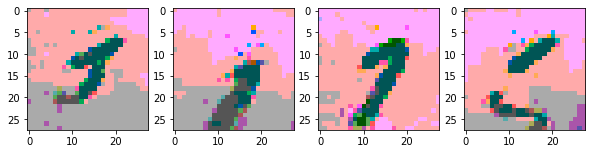

epoch: 20 i: 99 loss: 0.1003875881433487 val loss: 0.09586361795663834
epoch: 20 i: 199 loss: 0.09527677297592163 val loss: 0.09074489772319794
epoch: 20 i: 299 loss: 0.09085734933614731 val loss: 0.08711519837379456
epoch: 20 i: 399 loss: 0.08990973234176636 val loss: 0.0852179229259491
epoch: 20 i: 499 loss: 0.0865417942404747 val loss: 0.08412117511034012
epoch: 20 i: 599 loss: 0.09164982289075851 val loss: 0.08786461502313614


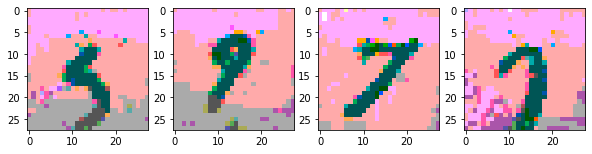

epoch: 21 i: 99 loss: 0.08540820330381393 val loss: 0.08308160305023193
epoch: 21 i: 199 loss: 0.0873022973537445 val loss: 0.08349967002868652
epoch: 21 i: 299 loss: 0.08627771586179733 val loss: 0.08323251456022263
epoch: 21 i: 399 loss: 0.08738104999065399 val loss: 0.08299057185649872
epoch: 21 i: 499 loss: 0.0840785801410675 val loss: 0.08223960548639297
epoch: 21 i: 599 loss: 0.08959639817476273 val loss: 0.0859389379620552


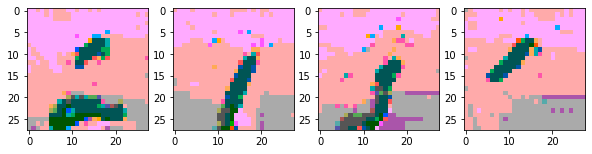

epoch: 22 i: 99 loss: 0.08385533839464188 val loss: 0.08197584748268127
epoch: 22 i: 199 loss: 0.08576016128063202 val loss: 0.08283239603042603
epoch: 22 i: 299 loss: 0.0857352614402771 val loss: 0.0826677531003952
epoch: 22 i: 399 loss: 0.08665162324905396 val loss: 0.08261346071958542
epoch: 22 i: 499 loss: 0.08391096442937851 val loss: 0.08203744143247604
epoch: 22 i: 599 loss: 0.08888205140829086 val loss: 0.08496997505426407


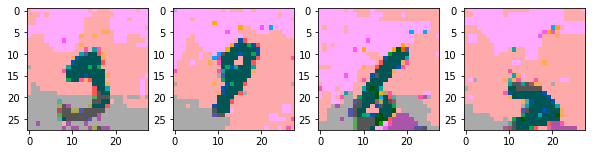

epoch: 23 i: 99 loss: 0.08318471163511276 val loss: 0.08162353187799454
epoch: 23 i: 199 loss: 0.0856710746884346 val loss: 0.08282172679901123
epoch: 23 i: 299 loss: 0.08539116382598877 val loss: 0.08281809836626053
epoch: 23 i: 399 loss: 0.086301289498806 val loss: 0.08247607946395874
epoch: 23 i: 499 loss: 0.08378393948078156 val loss: 0.08199558407068253
epoch: 23 i: 599 loss: 0.08878441154956818 val loss: 0.08499538898468018


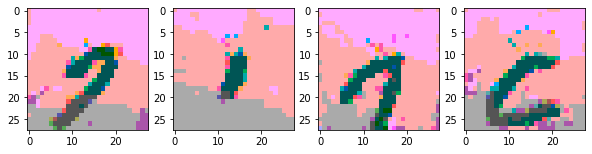

epoch: 24 i: 99 loss: 0.08266260474920273 val loss: 0.08152245730161667
epoch: 24 i: 199 loss: 0.08553758263587952 val loss: 0.08229025453329086
epoch: 24 i: 299 loss: 0.08503595739603043 val loss: 0.08257415890693665
epoch: 24 i: 399 loss: 0.08618766814470291 val loss: 0.08232094347476959
epoch: 24 i: 499 loss: 0.08360233157873154 val loss: 0.08181507140398026
epoch: 24 i: 599 loss: 0.08847858756780624 val loss: 0.0848638042807579


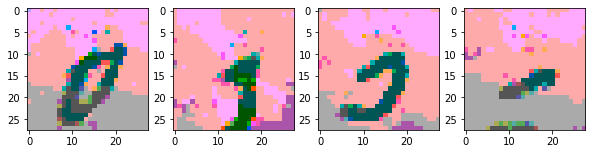

epoch: 25 i: 99 loss: 0.08242890238761902 val loss: 0.08159491419792175
epoch: 25 i: 199 loss: 0.08502062410116196 val loss: 0.0820823386311531
epoch: 25 i: 299 loss: 0.08501460403203964 val loss: 0.08239825069904327
epoch: 25 i: 399 loss: 0.08635449409484863 val loss: 0.08190568536520004
epoch: 25 i: 499 loss: 0.08372212946414948 val loss: 0.08206776529550552
epoch: 25 i: 599 loss: 0.08810651302337646 val loss: 0.0849984884262085


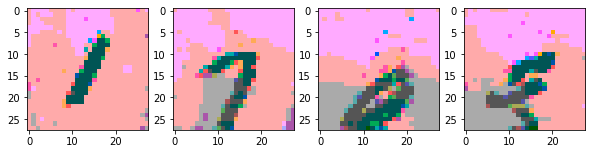

epoch: 26 i: 99 loss: 0.08235092461109161 val loss: 0.08115000277757645
epoch: 26 i: 199 loss: 0.0844629555940628 val loss: 0.08189240843057632
epoch: 26 i: 299 loss: 0.0844080001115799 val loss: 0.08237595111131668
epoch: 26 i: 399 loss: 0.08557607978582382 val loss: 0.08190270513296127
epoch: 26 i: 499 loss: 0.08322404325008392 val loss: 0.08164805173873901
epoch: 26 i: 599 loss: 0.0875566154718399 val loss: 0.08467715978622437


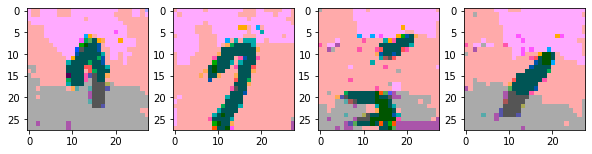

epoch: 27 i: 99 loss: 0.08230598270893097 val loss: 0.08104685693979263
epoch: 27 i: 199 loss: 0.10360084474086761 val loss: 0.09829262644052505
epoch: 27 i: 299 loss: 0.09541510790586472 val loss: 0.09216263145208359
epoch: 27 i: 399 loss: 0.09468300640583038 val loss: 0.0894484892487526
epoch: 27 i: 499 loss: 0.09031029045581818 val loss: 0.08701293915510178
epoch: 27 i: 599 loss: 0.09370634704828262 val loss: 0.08893155306577682


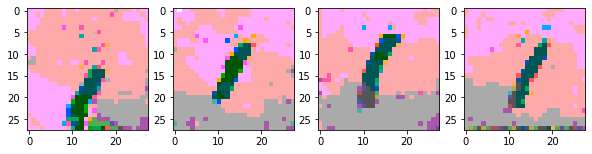

epoch: 28 i: 99 loss: 0.0871112123131752 val loss: 0.08441127091646194
epoch: 28 i: 199 loss: 0.08907854557037354 val loss: 0.08409061282873154
epoch: 28 i: 299 loss: 0.08623247593641281 val loss: 0.08336422592401505
epoch: 28 i: 399 loss: 0.08785740286111832 val loss: 0.08270145207643509
epoch: 28 i: 499 loss: 0.08458087593317032 val loss: 0.08235836029052734
epoch: 28 i: 599 loss: 0.08928535133600235 val loss: 0.08561230450868607


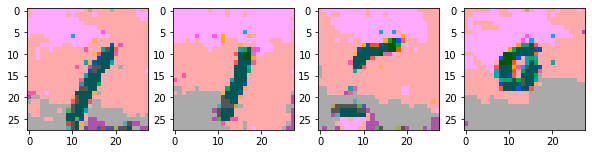

epoch: 29 i: 99 loss: 0.08339723944664001 val loss: 0.08167779445648193
epoch: 29 i: 199 loss: 0.08558729290962219 val loss: 0.08198472112417221
epoch: 29 i: 299 loss: 0.08468552678823471 val loss: 0.08197389543056488
epoch: 29 i: 399 loss: 0.08625029772520065 val loss: 0.08167605847120285
epoch: 29 i: 499 loss: 0.08350435644388199 val loss: 0.08135699480772018
epoch: 29 i: 599 loss: 0.08794017881155014 val loss: 0.08453123271465302


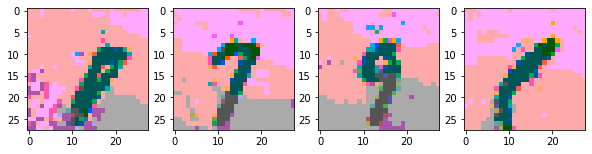

epoch: 30 i: 99 loss: 0.08237593621015549 val loss: 0.0811200737953186
epoch: 30 i: 199 loss: 0.08480066806077957 val loss: 0.08156410604715347
epoch: 30 i: 299 loss: 0.08408501744270325 val loss: 0.08167042583227158
epoch: 30 i: 399 loss: 0.08588560670614243 val loss: 0.08148449659347534
epoch: 30 i: 499 loss: 0.08314884454011917 val loss: 0.08124430477619171
epoch: 30 i: 599 loss: 0.08702414482831955 val loss: 0.08419563621282578


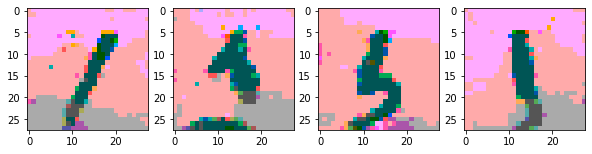

epoch: 31 i: 99 loss: 0.08187396079301834 val loss: 0.08091501891613007
epoch: 31 i: 199 loss: 0.08468843996524811 val loss: 0.08154525607824326
epoch: 31 i: 299 loss: 0.08386468887329102 val loss: 0.08150598406791687
epoch: 31 i: 399 loss: 0.08591480553150177 val loss: 0.08163812011480331
epoch: 31 i: 499 loss: 0.0829058438539505 val loss: 0.08104483783245087
epoch: 31 i: 599 loss: 0.08769433200359344 val loss: 0.08388986438512802


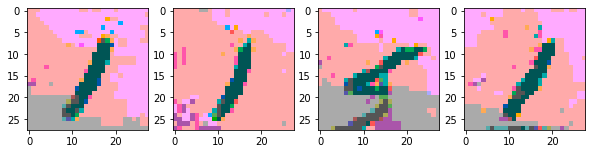

epoch: 32 i: 99 loss: 0.08187077939510345 val loss: 0.08090739697217941
epoch: 32 i: 199 loss: 0.08414511382579803 val loss: 0.08141928166151047
epoch: 32 i: 299 loss: 0.08357926458120346 val loss: 0.08146923780441284
epoch: 32 i: 399 loss: 0.08572537451982498 val loss: 0.08117740601301193
epoch: 32 i: 499 loss: 0.08275530487298965 val loss: 0.08115965127944946
epoch: 32 i: 599 loss: 0.08722476661205292 val loss: 0.08422363549470901


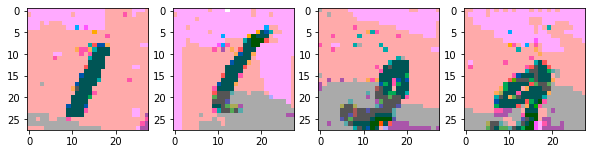

epoch: 33 i: 99 loss: 0.08176074177026749 val loss: 0.08060770481824875
epoch: 33 i: 199 loss: 0.08399669080972672 val loss: 0.08105549961328506
epoch: 33 i: 299 loss: 0.08340927213430405 val loss: 0.08133722096681595
epoch: 33 i: 399 loss: 0.0856303796172142 val loss: 0.08130661398172379
epoch: 33 i: 499 loss: 0.08271495997905731 val loss: 0.08097754418849945
epoch: 33 i: 599 loss: 0.086854487657547 val loss: 0.08368439972400665


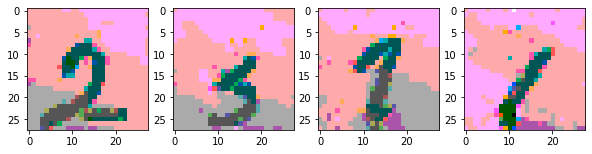

epoch: 34 i: 99 loss: 0.08168249577283859 val loss: 0.08071332424879074
epoch: 34 i: 199 loss: 0.08393222838640213 val loss: 0.08076492697000504
epoch: 34 i: 299 loss: 0.08348838239908218 val loss: 0.0813775509595871
epoch: 34 i: 399 loss: 0.08533016592264175 val loss: 0.08107529580593109
epoch: 34 i: 499 loss: 0.08264945447444916 val loss: 0.08063742518424988
epoch: 34 i: 599 loss: 0.08741048723459244 val loss: 0.0835033655166626


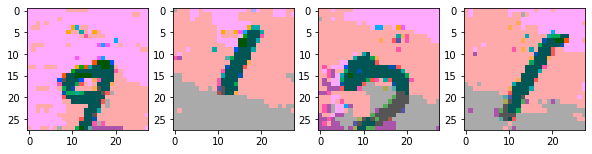

epoch: 35 i: 99 loss: 0.08162318170070648 val loss: 0.0802057683467865
epoch: 35 i: 199 loss: 0.08371145278215408 val loss: 0.08090740442276001
epoch: 35 i: 299 loss: 0.0833965539932251 val loss: 0.08127152174711227
epoch: 35 i: 399 loss: 0.08528489619493484 val loss: 0.08102407306432724
epoch: 35 i: 499 loss: 0.08264372497797012 val loss: 0.08090599626302719
epoch: 35 i: 599 loss: 0.08733846247196198 val loss: 0.08364361524581909


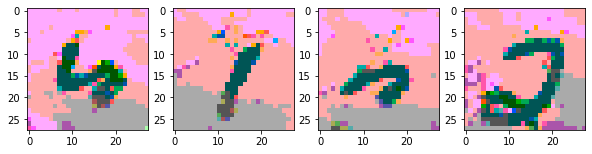

epoch: 36 i: 99 loss: 0.08153092116117477 val loss: 0.08077487349510193
epoch: 36 i: 199 loss: 0.08374981582164764 val loss: 0.08082590997219086
epoch: 36 i: 299 loss: 0.08347144722938538 val loss: 0.08123783767223358
epoch: 36 i: 399 loss: 0.08506760001182556 val loss: 0.08095824718475342
epoch: 36 i: 499 loss: 0.08273385465145111 val loss: 0.0807863399386406
epoch: 36 i: 599 loss: 0.08675789088010788 val loss: 0.08385045826435089


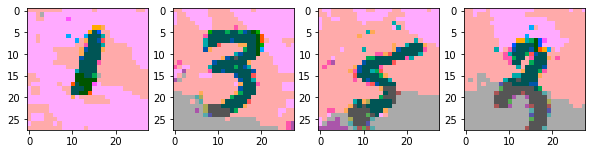

epoch: 37 i: 99 loss: 0.08139333873987198 val loss: 0.08034496009349823
epoch: 37 i: 199 loss: 0.08367229253053665 val loss: 0.08125444501638412
epoch: 37 i: 299 loss: 0.08295632153749466 val loss: 0.08122077584266663
epoch: 37 i: 399 loss: 0.08509649336338043 val loss: 0.08097465336322784
epoch: 37 i: 499 loss: 0.08221909403800964 val loss: 0.08065871149301529
epoch: 37 i: 599 loss: 0.08633009344339371 val loss: 0.08363780379295349


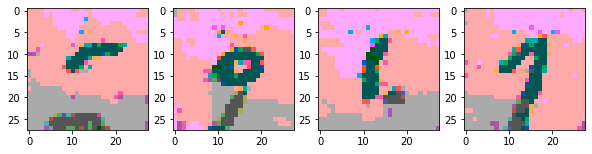

epoch: 38 i: 99 loss: 0.08142468333244324 val loss: 0.08048118650913239
epoch: 38 i: 199 loss: 0.08746413141489029 val loss: 0.08308220654726028
epoch: 38 i: 299 loss: 0.08381179720163345 val loss: 0.08167948573827744
epoch: 38 i: 399 loss: 0.08518023043870926 val loss: 0.08073486387729645
epoch: 38 i: 499 loss: 0.0822044089436531 val loss: 0.0803947001695633
epoch: 38 i: 599 loss: 0.0870751217007637 val loss: 0.08404234796762466


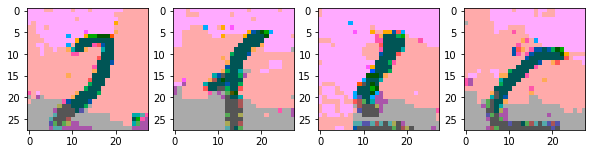

epoch: 39 i: 99 loss: 0.08122299611568451 val loss: 0.08045889437198639
epoch: 39 i: 199 loss: 0.08355584740638733 val loss: 0.08036959171295166
epoch: 39 i: 299 loss: 0.08276797831058502 val loss: 0.08069314062595367
epoch: 39 i: 399 loss: 0.08466911315917969 val loss: 0.08027282357215881
epoch: 39 i: 499 loss: 0.08186068385839462 val loss: 0.08032754063606262
epoch: 39 i: 599 loss: 0.08646513521671295 val loss: 0.0836607962846756


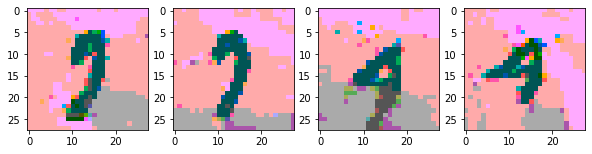

epoch: 40 i: 99 loss: 0.08084036409854889 val loss: 0.08028092235326767
epoch: 40 i: 199 loss: 0.08348529785871506 val loss: 0.08059270679950714
epoch: 40 i: 299 loss: 0.08278867602348328 val loss: 0.08060112595558167
epoch: 40 i: 399 loss: 0.08478374779224396 val loss: 0.08061567693948746
epoch: 40 i: 499 loss: 0.08214486390352249 val loss: 0.08048400282859802
epoch: 40 i: 599 loss: 0.08676022291183472 val loss: 0.08351749181747437


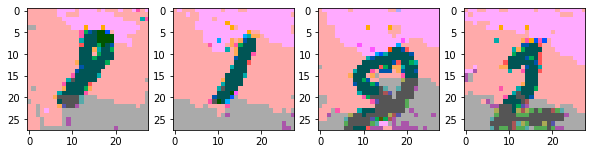

epoch: 41 i: 99 loss: 0.08117431402206421 val loss: 0.07999294996261597
epoch: 41 i: 199 loss: 0.08326277881860733 val loss: 0.08056820183992386
epoch: 41 i: 299 loss: 0.08259627223014832 val loss: 0.08124717324972153
epoch: 41 i: 399 loss: 0.08472106605768204 val loss: 0.0805123820900917
epoch: 41 i: 499 loss: 0.08171901851892471 val loss: 0.0801510363817215
epoch: 41 i: 599 loss: 0.08647152781486511 val loss: 0.08307243138551712


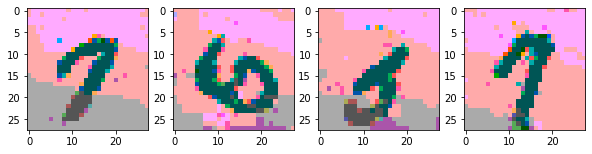

epoch: 42 i: 99 loss: 0.08092911541461945 val loss: 0.0803614929318428
epoch: 42 i: 199 loss: 0.0831919014453888 val loss: 0.08053580671548843
epoch: 42 i: 299 loss: 0.08289121091365814 val loss: 0.08070766925811768
epoch: 42 i: 399 loss: 0.08462321013212204 val loss: 0.08050655573606491
epoch: 42 i: 499 loss: 0.08196454495191574 val loss: 0.08012647181749344
epoch: 42 i: 599 loss: 0.08640002459287643 val loss: 0.0830511525273323


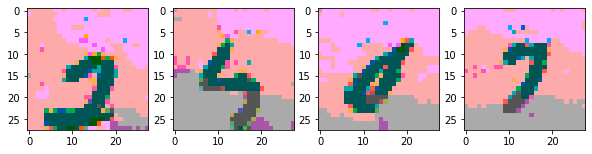

epoch: 43 i: 99 loss: 0.08092597126960754 val loss: 0.08037059009075165
epoch: 43 i: 199 loss: 0.08333378285169601 val loss: 0.08062781393527985
epoch: 43 i: 299 loss: 0.08266269415616989 val loss: 0.08062828332185745
epoch: 43 i: 399 loss: 0.08474941551685333 val loss: 0.0804564580321312
epoch: 43 i: 499 loss: 0.08200427144765854 val loss: 0.08029291778802872
epoch: 43 i: 599 loss: 0.08642866462469101 val loss: 0.08308986574411392


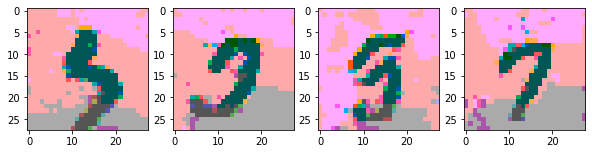

epoch: 44 i: 99 loss: 0.08091782033443451 val loss: 0.0799398198723793
epoch: 44 i: 199 loss: 0.0830119401216507 val loss: 0.08036341518163681
epoch: 44 i: 299 loss: 0.08249472826719284 val loss: 0.08017870783805847
epoch: 44 i: 399 loss: 0.08476265519857407 val loss: 0.08051132410764694
epoch: 44 i: 499 loss: 0.08219584822654724 val loss: 0.0802314355969429
epoch: 44 i: 599 loss: 0.08651766926050186 val loss: 0.08334892988204956


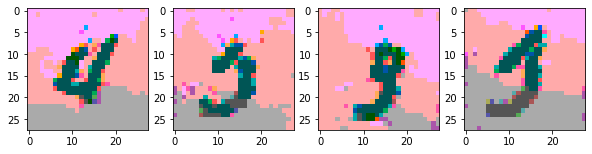

epoch: 45 i: 99 loss: 0.081080362200737 val loss: 0.08018840104341507
epoch: 45 i: 199 loss: 0.08289134502410889 val loss: 0.08066005259752274
epoch: 45 i: 299 loss: 0.08235005289316177 val loss: 0.08054876327514648
epoch: 45 i: 399 loss: 0.08457046747207642 val loss: 0.08049222826957703
epoch: 45 i: 499 loss: 0.0817907527089119 val loss: 0.0803074762225151
epoch: 45 i: 599 loss: 0.08639217168092728 val loss: 0.08297025412321091


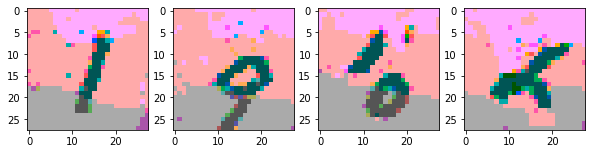

epoch: 46 i: 99 loss: 0.0810014083981514 val loss: 0.07998047024011612
epoch: 46 i: 199 loss: 0.08298957347869873 val loss: 0.08072370290756226
epoch: 46 i: 299 loss: 0.08241606503725052 val loss: 0.08021006733179092
epoch: 46 i: 399 loss: 0.08472207188606262 val loss: 0.0802268385887146
epoch: 46 i: 499 loss: 0.08166807144880295 val loss: 0.079922616481781
epoch: 46 i: 599 loss: 0.0975852981209755 val loss: 0.08393702656030655


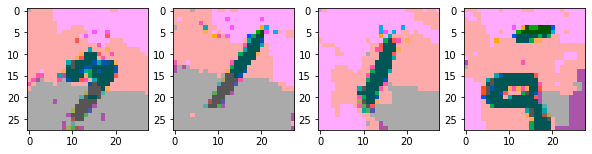

epoch: 47 i: 99 loss: 0.08760523051023483 val loss: 0.08549710363149643
epoch: 47 i: 199 loss: 0.08678285777568817 val loss: 0.08301585912704468
epoch: 47 i: 299 loss: 0.08414812386035919 val loss: 0.08211079984903336
epoch: 47 i: 399 loss: 0.0860186293721199 val loss: 0.08126427233219147
epoch: 47 i: 499 loss: 0.08286509662866592 val loss: 0.08073628693819046
epoch: 47 i: 599 loss: 0.08716095238924026 val loss: 0.08343254029750824


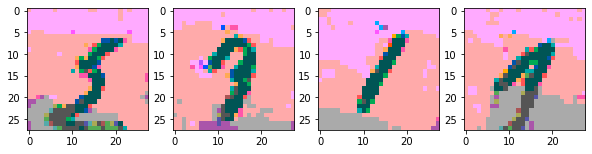

epoch: 48 i: 99 loss: 0.08154414594173431 val loss: 0.08080298453569412
epoch: 48 i: 199 loss: 0.08349579572677612 val loss: 0.08055050671100616
epoch: 48 i: 299 loss: 0.0822400376200676 val loss: 0.08043351024389267
epoch: 48 i: 399 loss: 0.08490181714296341 val loss: 0.08029676973819733
epoch: 48 i: 499 loss: 0.08183269202709198 val loss: 0.08009672909975052
epoch: 48 i: 599 loss: 0.0858360081911087 val loss: 0.08289193361997604


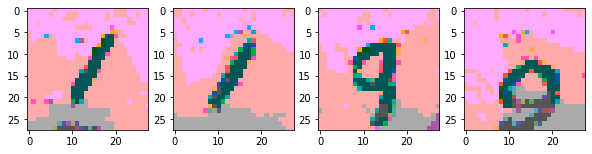

epoch: 49 i: 99 loss: 0.08109287172555923 val loss: 0.08020080626010895
epoch: 49 i: 199 loss: 0.08300204575061798 val loss: 0.08030864596366882
epoch: 49 i: 299 loss: 0.08202952891588211 val loss: 0.08014605939388275
epoch: 49 i: 399 loss: 0.08429228514432907 val loss: 0.08007035404443741
epoch: 49 i: 499 loss: 0.08165633678436279 val loss: 0.08011410385370255
epoch: 49 i: 599 loss: 0.0861269012093544 val loss: 0.08276227116584778


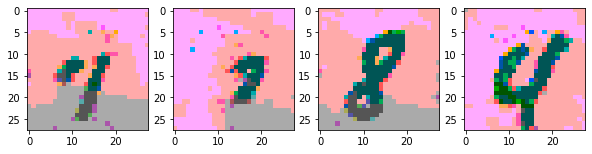

In [20]:
pixelCNN.train(True)
EPOCH = 50
train_loss = []
val_loss = []
j = 0
for epoch in range(EPOCH):
  pixelCNN.train()
  for i, labels in enumerate(trainloader, 0):
    labels = labels.to(device)
    # print("Labels:", labels.shape)
   
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = pixelCNN(labels.float())
    # print("Outout:", outputs.shape)
    loss = criterion(outputs, labels.long())
    
    loss.backward()
    optimizer.step()

    loss = loss.item()
    # print statistics
    j += 1 
    if ((i+1) % 100 == 0):
      with torch.set_grad_enabled(False):
        val_batch = next(iter(testloader))
        val_batch = val_batch.to(device)

        val_output = pixelCNN(val_batch.float())
        val_loss_item = criterion(val_output, val_batch.long()).item()
        val_loss.append(val_loss_item)
      
      
      
    train_loss.append(loss)
  sample_image()

Train loss: 


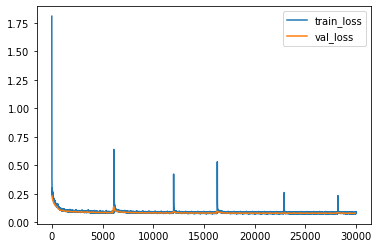

In [21]:
print("Train loss: ")
plt.plot(train_loss, label = "train_loss")
plt.plot(np.arange(0, len(train_loss),int(len(train_loss)/len(val_loss))),val_loss, label = "val_loss")
plt.legend()
plt.show()


In [0]:
# save
torch.save(pixelCNN.state_dict(), 'drive/My Drive/Colab Notebooks/pixel_cnn_model')

In [24]:
# load
pixelCNN = PixelCNN(128).to(device)
pixelCNN.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/pixel_cnn_model'))

<All keys matched successfully>

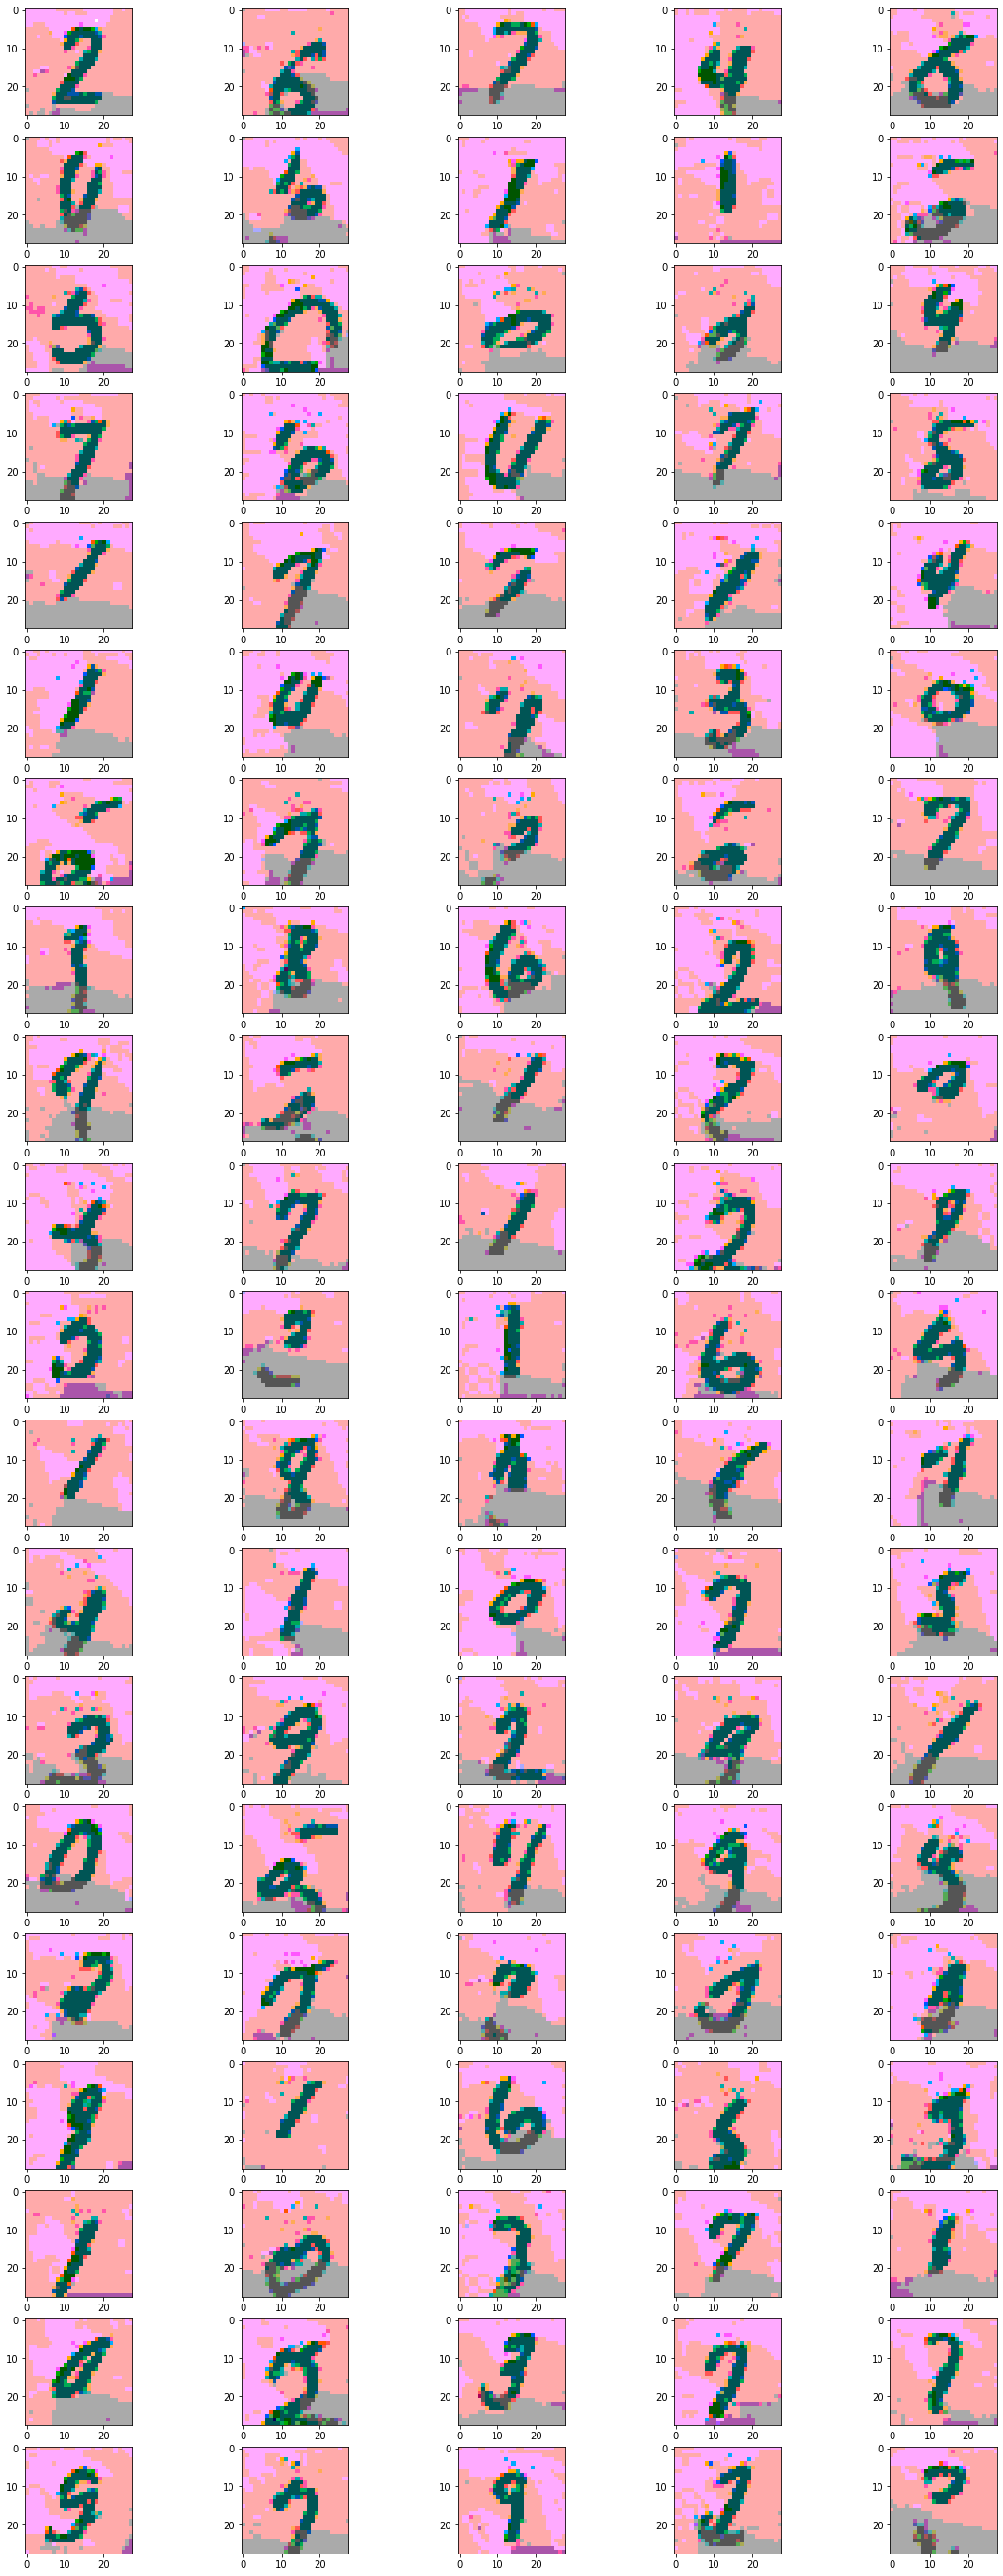

In [25]:
images = sample_image(100)

In [0]:
# Saving images
torchvision.utils.save_image(torch.from_numpy(images).permute(0,3,1,2), 'drive/My Drive/Colab Notebooks/sample.png', nrow=10, padding=0)

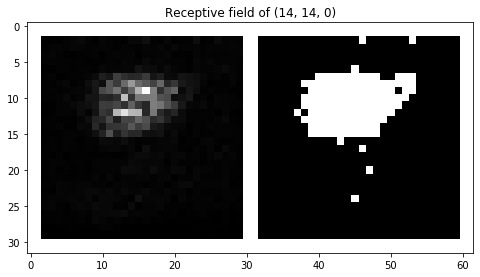

In [27]:
X_train = torch.as_tensor(train[0], device=device).permute(2, 0, 1)
random_model = PixelCNN().to(device)
random_input = X_train.clone().detach().float().unsqueeze(0).requires_grad_(True)
   
logits = random_model(random_input)
log_probs = torch.nn.functional.log_softmax(logits, dim=1)
log_probs[0, :, 0, 14, 14].sum().backward()

max_grad = random_input.grad.abs().max(dim=1)[0]
visualization1 = max_grad / max_grad.max()
visualization2 = (visualization1 > 5e-2).float()
visualization_grid = torchvision.utils.make_grid([visualization1, visualization2], pad_value=1.)

plt.figure(figsize=(8,8))
plt.title('Receptive field of (14, 14, 0)')
plt.imshow(visualization_grid.permute(1, 2, 0).cpu().numpy());